In [59]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np

# various options in pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 1. Load Data

In [16]:
from urllib.request import HTTPError

def load_turnstile_data(urls):
    dfs = []
    for url in urls:
        try:
            df = pd.read_csv(url)
            dfs.append(df)
        except HTTPError as err:
            if err.code == 404:
                continue
            else:
                raise err
    return pd.concat(dfs).reset_index()

def format_day_month(num):
    return '0' + str(num) if num < 10 else str(num)

def format_year(num):
    return str(num)[-2:]

def generate_url(date):
    y = format_year(date.year)
    m = format_day_month(date.month)
    d = format_day_month(date.day)
    return f'http://web.mta.info/developers/data/nyct/turnstile/turnstile_{y}{m}{d}.txt'

In [14]:
def fetch_data_for_week_range(start, end):
    assert pd.to_datetime(start).weekday() == 5, "Start must be a Saturday to match turnstile data"
    assert pd.to_datetime(start).weekday() == 5, "End must be a Saturday to match turnstile data"
    
    urls = list(map(generate_url, pd.date_range(start, end, freq="7D")))
    return load_turnstile_data(urls)

In [15]:
mta_data = fetch_data_for_week_range('3/2/2019', '3/30/2019')

2019-03-02 00:00:00
2019-03-09 00:00:00
2019-03-16 00:00:00
2019-03-23 00:00:00
2019-03-30 00:00:00


In [17]:
with open('mta_data_march.pickle', 'wb') as write_file:
    pickle.dump(mta_data, write_file)

In [18]:
mta_data.shape

(1016285, 11)

In [38]:
mta_data.DESC.value_counts()

REGULAR       1011676
RECOVR AUD       4609
Name: DESC, dtype: int64

# 2. Clean Data

In [161]:
with open('mta_data_march.pickle', 'rb') as read_file:
    mta_data = pickle.load(read_file).reset_index()

In [162]:
mta_data.columns

Index(['index', 'C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION',
       'DATE', 'TIME', 'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [163]:
mta_data.columns = [col.strip() for col in mta_data.columns]

In [164]:
mta_data = mta_data.sort_values(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME'])

## 2.0 Check For Duplicates

### 2.0.1 How many duplicates are there?

In [165]:
by_unique_count = mta_data.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME']).agg({ 'ENTRIES': 'count'}).reset_index()

In [166]:
# There are 57 duplicate entries
by_unique_count[by_unique_count.ENTRIES > 1].shape

(57, 7)

### 2.0.2 Duplicates Exploration

In [167]:
mta_data['num_dups'] = mta_data.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME'])['ENTRIES'].transform('count')

In [168]:
with_dups = mta_data[mta_data.num_dups > 1].sort_values(['C/A', 'UNIT', 'SCP', 'STATION', 'num_dups'])

In [169]:
with_dups.shape

(114, 13)

In [170]:
with_dups.describe()

,index,ENTRIES,EXITS,num_dups
count,114.000,114.000,114.000,114.000
mean,75263.798,7068988.395,7762899.395,2.000
std,38036.586,6172817.503,6717998.744,0.000
min,5067.000,2471.000,0.000,2.000
25%,53694.250,2114976.000,1451309.750,2.000
50%,53902.500,5870442.000,7068961.500,2.000
75%,100251.750,9699393.750,10685032.750,2.000
max,146153.000,18100105.000,18839460.000,2.000


In [171]:
with_dups.DESC.unique()

array(['REGULAR', 'RECOVR AUD'], dtype=object)

In [172]:
with_dups.groupby(['DESC']).agg('count')

,index,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,EXITS,num_dups
DESC,,,,,,,,,,,,
RECOVR AUD,57,57,57,57,57,57,57,57,57,57,57,57
REGULAR,57,57,57,57,57,57,57,57,57,57,57,57


In [173]:
across_desc = pd.pivot_table(with_dups,
               values='ENTRIES',
               columns='DESC',
               index=['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME'],
               aggfunc='mean')


In [174]:
across_desc['diff'] = across_desc['RECOVR AUD'] - across_desc['REGULAR']

In [175]:
across_desc['diff'].describe()

count          57.000
mean     -4023566.404
std       6243779.993
min     -10314855.000
25%     -10314674.000
50%      -5383636.000
75%        131439.000
max      16148594.000
Name: diff, dtype: float64

In [176]:
mta_data['prev_entries'] = mta_data.groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['ENTRIES'].transform(lambda grp: grp.shift(1))
mta_data['prev_desc'] = mta_data.groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['DESC'].transform(lambda grp: grp.shift(1))


In [177]:
mta_data['next_entries'] = mta_data.groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['ENTRIES'].transform(lambda grp: grp.shift(-1))
mta_data['next_desc'] = mta_data.groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['DESC'].transform(lambda grp: grp.shift(-1))



In [178]:
across_desc = across_desc.reset_index()

In [179]:
across_desc = across_desc.merge(
    mta_data[['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME', 'DESC', 'prev_entries', 'prev_desc', 'next_entries', 'next_desc']],
    how='inner',
    on=['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME']
)

In [180]:
across_desc[across_desc['diff'] > 100].shape

(34, 14)

In [181]:
across_desc[across_desc['diff'] > 100].head(34)

,C/A,UNIT,SCP,STATION,DATE,TIME,RECOVR AUD,REGULAR,diff,DESC,prev_entries,prev_desc,next_entries,next_desc
12,N071,R013,00-00-00,34 ST-PENN STA,02/27/2019,19:00:00,5870225,2196639,3673586,REGULAR,5869852.000,REGULAR,5870225.000,RECOVR AUD
13,N071,R013,00-00-00,34 ST-PENN STA,02/27/2019,19:00:00,5870225,2196639,3673586,RECOVR AUD,2196639.000,REGULAR,2196693.000,REGULAR
14,N071,R013,00-00-00,34 ST-PENN STA,02/27/2019,23:00:00,5870426,2196693,3673733,REGULAR,5870225.000,RECOVR AUD,5870426.000,RECOVR AUD
15,N071,R013,00-00-00,34 ST-PENN STA,02/27/2019,23:00:00,5870426,2196693,3673733,RECOVR AUD,2196693.000,REGULAR,2196699.000,REGULAR
16,N071,R013,00-00-00,34 ST-PENN STA,02/28/2019,03:00:00,5870458,2196699,3673759,REGULAR,5870426.000,RECOVR AUD,5870458.000,RECOVR AUD
17,N071,R013,00-00-00,34 ST-PENN STA,02/28/2019,03:00:00,5870458,2196699,3673759,RECOVR AUD,2196699.000,REGULAR,2196731.000,REGULAR
18,N071,R013,00-00-00,34 ST-PENN STA,02/28/2019,07:00:00,5870469,2196732,3673737,REGULAR,2196731.000,REGULAR,5870469.000,RECOVR AUD
19,N071,R013,00-00-00,34 ST-PENN STA,02/28/2019,07:00:00,5870469,2196732,3673737,RECOVR AUD,2196732.000,REGULAR,5870625.000,REGULAR
20,N071,R013,00-00-01,34 ST-PENN STA,02/27/2019,19:00:00,3172052,2224501,947551,REGULAR,3171790.000,REGULAR,3172052.000,RECOVR AUD
21,N071,R013,00-00-01,34 ST-PENN STA,02/27/2019,19:00:00,3172052,2224501,947551,RECOVR AUD,2224501.000,REGULAR,2224575.000,REGULAR


#### Possible Remedies

There are only 34 duplicates with meaningfully different values which we can visually inspect in their entirety. With the exception of HOUSTON ST, the "RECOVR AUD" is the correct value based on which value more closely matches the preceeding value and the post-ceeding value.

Option 1: Clean this specific data
1. Remove Houston ST REGULAR record individually
2. Remove all other duplicates, choosing the RECOVR AUD

However, this would couple the cleaning notebook to this specific dataset

Option 2: Assume RECOVR AUD is always more accurate
1. Remove all duplicates, choosing the RECOVR AUD

It's unclear if this assumption would hold with other datasets

Option 3: Remove any record that has a duplicate (assume it will usually be a small number)
1. Remove all records with a duplicate

#### Choice: Option 2. Semantically, it seems plausible that a "recovery" reading would be the correct one


### 2.0.3 Remove Duplicates

In [183]:
mta_data = mta_data.sort_values(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME', 'DESC'])
mta_data = mta_data.drop_duplicates(subset=['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME'], keep='first')

In [185]:
# validate
mta_data.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME'])\
    .agg({ 'ENTRIES': 'count'})\
    .reset_index()\
    .ENTRIES.unique()

array([1])

## 2.1 Subset Data

In [85]:
mta_data.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,03:00:00,REGULAR,6955483,2359112
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,07:00:00,REGULAR,6955494,2359125
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,11:00:00,REGULAR,6955554,2359199
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,15:00:00,REGULAR,6955714,2359248
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,02/23/2019,19:00:00,REGULAR,6956004,2359292


In [110]:
subset = mta_data[['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME', 'ENTRIES']].copy()

## 2.2 Convert Dates

In [111]:
subset['datetime'] = pd.to_datetime(subset.DATE + ' ' + subset.TIME)
subset['DATE'] = pd.to_datetime(subset.DATE)
subset['TIME'] = pd.to_datetime(subset.TIME).dt.time

## 2.3 Calculate Entries for Each Time Interval

In [112]:
sorted_data = subset.sort_values(['C/A', 'UNIT', 'SCP', 'STATION', 'datetime'])

In [114]:
sorted_data['entries_since_last_record'] = sorted_data.groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['ENTRIES'].shift(1)


In [100]:
sorted_data['time_interval'] = sorted_data.groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['datetime'].diff(1)

In [454]:
sorted_data.head(20)

,C/A,UNIT,SCP,STATION,DATE,TIME,ENTRIES,datetime,entries_since_last_record,time_interval,mad,unit_mean,unit_std,deviations
0,A002,R051,02-00-00,59 ST,2019-02-23,03:00:00,6955483,2019-02-23 03:00:00,nan,NaT,A002,202.453,225.514,nan
1,A002,R051,02-00-00,59 ST,2019-02-23,07:00:00,6955494,2019-02-23 07:00:00,11.000,04:00:00,A002,202.453,225.514,-0.849
2,A002,R051,02-00-00,59 ST,2019-02-23,11:00:00,6955554,2019-02-23 11:00:00,60.000,04:00:00,A002,202.453,225.514,-0.632
3,A002,R051,02-00-00,59 ST,2019-02-23,15:00:00,6955714,2019-02-23 15:00:00,160.000,04:00:00,A002,202.453,225.514,-0.188
4,A002,R051,02-00-00,59 ST,2019-02-23,19:00:00,6956004,2019-02-23 19:00:00,290.000,04:00:00,A002,202.453,225.514,0.388
5,A002,R051,02-00-00,59 ST,2019-02-23,23:00:00,6956147,2019-02-23 23:00:00,143.000,04:00:00,A002,202.453,225.514,-0.264
6,A002,R051,02-00-00,59 ST,2019-02-24,03:00:00,6956177,2019-02-24 03:00:00,30.000,04:00:00,A002,202.453,225.514,-0.765
7,A002,R051,02-00-00,59 ST,2019-02-24,07:00:00,6956184,2019-02-24 07:00:00,7.000,04:00:00,A002,202.453,225.514,-0.867
8,A002,R051,02-00-00,59 ST,2019-02-24,11:00:00,6956215,2019-02-24 11:00:00,31.000,04:00:00,A002,202.453,225.514,-0.760
9,A002,R051,02-00-00,59 ST,2019-02-24,15:00:00,6956315,2019-02-24 15:00:00,100.000,04:00:00,A002,202.453,225.514,-0.454


## 2.4 Visualize Outliers

Text(0, 0.5, 'Number of Entries')

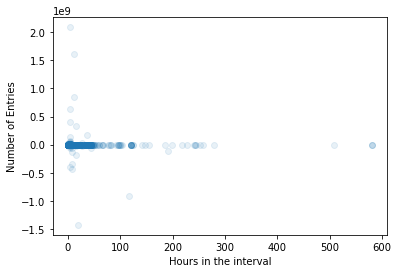

In [112]:
interval_in_hours = sorted_data.time_interval.dt.total_seconds() / 3600

plt.scatter(interval_in_hours, sorted_data.entries_since_last_record, alpha=0.1)
plt.xlabel('Hours in the interval')
plt.ylabel('Number of Entries')
plt.title('Raw')

(-3000, 5000)

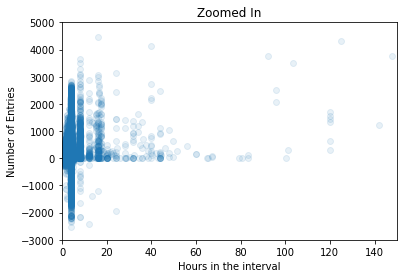

In [114]:
plt.scatter(hours, sorted_data.entries_since_last_record, alpha=0.1)
plt.xlabel('Hours in the interval')
plt.ylabel('Number of Entries')
plt.title('Zoomed In')
plt.xlim([0,150])
plt.ylim([-3000, 5000])

Conclusion: high entries values are not due to long time intervals for counting

In [118]:
sorted_data.time_interval.quantile(0.999).total_seconds() / 3600

8.0

In [119]:
sorted_data.entries_since_last_record.quantile(0.999)

1913.0

In [137]:
sorted_data.entries_since_last_record.quantile(0.0091)

-1.0

Conclusion: Could remove all intervals above 8 hrs, all negative entries values, and all entries values above 1913 and still only remove ~1.1% of the data set

## 2.5 Calculate Outliers Within A Turnstile

In [164]:
sorted_data['unit_mean'] = sorted_data.groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['entries_since_last_record'].transform('mean')

In [165]:
sorted_data['unit_std'] = sorted_data.groupby(['C/A', 'UNIT', 'SCP', 'STATION'])['entries_since_last_record'].transform('std')

In [169]:
sorted_data['deviations'] = (sorted_data['entries_since_last_record'] - sorted_data['unit_mean']) / sorted_data['unit_std']


In [173]:
sorted_data.describe([0.0001, 0.001, 0.01, 0.1, 0.9, 0.99, 0.999, 0.9999])

,ENTRIES,entries_since_last_record,time_interval,unit_mean,unit_std,deviations
count,1016285.000,1011402.000,1011402,1016271.000,1016265.000,960222.000
mean,40529956.499,2066.048,0 days 03:59:39.541903,2064.916,151249.407,0.000
std,208311278.270,3421941.072,0 days 01:36:09.342946,234270.500,3418951.384,0.998
min,0.000,-1428035580.000,0 days 00:00:00,-7069372.589,0.000,-14.933
0.01%,0.000,-1791052.851,0 days 00:00:08,-7069372.589,0.000,-13.711
0.1%,0.000,-825.000,0 days 00:01:20,-642517.976,0.000,-1.785
1%,0.000,0.000,0 days 01:20:56,-9349.700,0.000,-1.351
10%,18391.000,0.000,0 days 04:00:00,0.048,0.951,-0.991
50%,2285667.000,68.000,0 days 04:00:00,137.986,143.202,-0.186
90%,15417265.600,479.000,0 days 04:00:00,364.577,380.190,1.428


## 2.6 Remove Within Unit Outliers

In [207]:
no_unit_outliers = sorted_data[((sorted_data.deviations > -5) & (sorted_data.deviations < 5)) | sorted_data.deviations.isna()]

In [208]:
no_unit_outliers.shape[0] / sorted_data.shape[0]

0.9990711267016634

## 2.7 Visualize Without Unit Outliers

Text(0.5, 1.0, 'Raw')

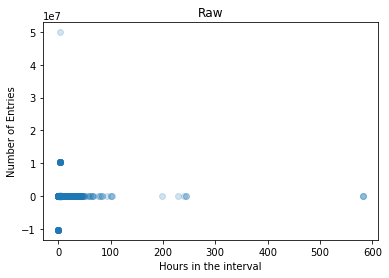

In [456]:
interval_in_hours = no_unit_outliers.time_interval.dt.total_seconds() / 3600

plt.scatter(interval_in_hours, no_unit_outliers.entries_since_last_record, alpha=0.2)
plt.xlabel('Hours in the interval')
plt.ylabel('Number of Entries')
plt.title('Raw')


In [210]:
no_unit_outliers.describe([0.0001, 0.001, 0.01, 0.1, 0.9, 0.99, 0.999, 0.9999])

,ENTRIES,entries_since_last_record,time_interval,unit_mean,unit_std,deviations
count,1015341.000,1010458.000,1010458,1015327.000,1015321.000,959278.000
mean,40537504.316,217.006,0 days 03:59:14.722463,2058.965,150540.900,-0.004
std,208328233.072,82970.949,0 days 01:16:05.855198,233812.099,3411897.994,0.955
min,0.000,-10314855.000,0 days 00:00:00,-7069372.589,0.000,-4.948
0.01%,0.000,-1658.954,0 days 00:00:18,-7069372.589,0.000,-2.750
0.1%,0.000,-727.000,0 days 00:01:20,-642517.976,0.000,-1.665
1%,0.000,0.000,0 days 01:20:59,-9349.700,0.000,-1.349
10%,18646.000,0.000,0 days 04:00:00,0.048,0.968,-0.991
50%,2290987.000,68.000,0 days 04:00:00,138.129,143.222,-0.187
90%,15416988.000,478.000,0 days 04:00:00,364.577,380.190,1.420


## 2.8 Remove Extreme Entries Outliers

In [217]:
no_extreme_outliers = no_unit_outliers[
    (no_unit_outliers.entries_since_last_record < no_unit_outliers.entries_since_last_record.quantile(0.99995)) & 
    (no_unit_outliers.entries_since_last_record > no_unit_outliers.entries_since_last_record.quantile(0.00005))]

Text(0.5, 1.0, 'Raw')

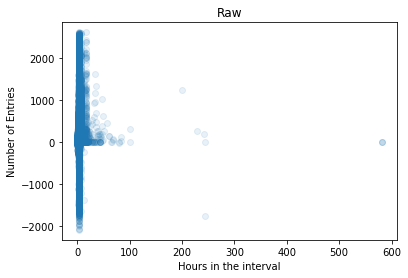

In [218]:
interval_in_hours = no_extreme_outliers.time_interval.dt.total_seconds() / 3600

plt.scatter(interval_in_hours, no_extreme_outliers.entries_since_last_record, alpha=0.1)
plt.xlabel('Hours in the interval')
plt.ylabel('Number of Entries')
plt.title('Raw')

## 2.9 Remove Extreme Interval Outliers

In [220]:
no_extreme_outliers.describe([0.0001, 0.001, 0.01, 0.1, 0.9, 0.99, 0.999, 0.9999])

,ENTRIES,entries_since_last_record,time_interval,unit_mean,unit_std,deviations
count,1010356.000,1010356.000,1010356,1010356.000,1010353.000,959176.000
mean,40529168.748,167.707,0 days 03:59:13.490501,2044.986,150125.708,-0.004
std,208302536.217,257.439,0 days 01:15:26.454563,233540.788,3408202.641,0.955
min,0.000,-2092.000,0 days 00:00:00,-7069372.589,0.000,-4.530
0.01%,0.000,-1505.929,0 days 00:00:31,-7069372.589,0.000,-2.689
0.1%,0.000,-706.645,0 days 00:01:20,-642517.976,0.000,-1.652
1%,0.000,0.000,0 days 01:21:15,-9349.700,0.000,-1.349
10%,18664.000,0.000,0 days 04:00:00,0.048,0.968,-0.991
50%,2290595.000,68.000,0 days 04:00:00,138.129,143.222,-0.187
90%,15413273.500,478.000,0 days 04:00:00,364.577,379.898,1.419


In [222]:
no_extreme_interval_outliers = no_extreme_outliers[no_extreme_outliers.time_interval < no_extreme_outliers.time_interval.quantile(0.99995)]

In [223]:
no_extreme_interval_outliers.shape[0] / no_extreme_outliers.shape[0]

0.9999495227424788

Text(0.5, 1.0, 'Raw')

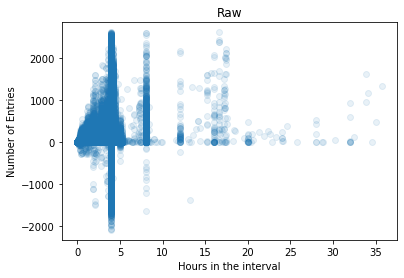

In [224]:
interval_in_hours = no_extreme_interval_outliers.time_interval.dt.total_seconds() / 3600

plt.scatter(interval_in_hours, no_extreme_interval_outliers.entries_since_last_record, alpha=0.1)
plt.xlabel('Hours in the interval')
plt.ylabel('Number of Entries')
plt.title('Raw')

In [227]:
# Status - the percent we've removed thus far
1 - (no_extreme_interval_outliers.shape[0] / mta_data.shape[0])

0.005884176190733892

## 2.10 Investigate Negatives

In [237]:
no_extreme_interval_outliers['always_decreasing'] = no_extreme_interval_outliers.groupby(['C/A', 'UNIT', 'SCP', 'STATION']).transform(lambda s: s.is_monotonic_decreasing)['ENTRIES']


/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [259]:
always_decreasing = no_extreme_interval_outliers[
    (no_extreme_interval_outliers.entries_since_last_record < 0) &
    no_extreme_interval_outliers.always_decreasing &
    no_extreme_interval_outliers.unit_mean != 0
]

In [264]:
always_decreasing.describe([0.0001, 0.001, 0.01, 0.1, 0.9, 0.99, 0.999, 0.9999])

,ENTRIES,entries_since_last_record,time_interval,unit_mean,unit_std,deviations
count,8607.000,8607.000,8607,8607.000,8607.000,8607.000
mean,1198984225.002,-294.060,0 days 03:57:03.137911,-290.659,269.349,-0.031
std,661311811.510,331.913,0 days 00:29:02.202133,156.279,140.238,0.996
min,8695.000,-2092.000,0 days 00:00:56,-660.356,0.591,-4.530
0.01%,8976.416,-2082.533,0 days 00:01:14.933200,-660.356,0.591,-4.530
0.1%,10617.356,-1884.970,0 days 00:01:20,-660.356,0.591,-3.487
1%,25203.800,-1537.940,0 days 00:31:36.320000,-660.356,43.866,-2.711
10%,98304563.000,-715.400,0 days 04:00:00,-549.857,83.564,-1.566
50%,1291172679.000,-186.000,0 days 04:00:00,-279.582,262.773,0.218
90%,1942995409.400,-14.000,0 days 04:00:00,-84.701,492.438,1.007


Text(0.5, 1.0, 'Raw')

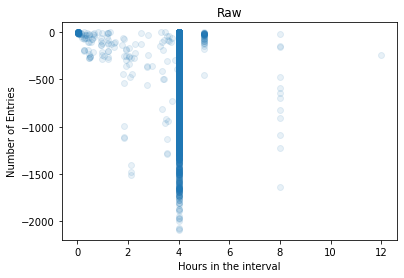

In [261]:
interval_in_hours = always_decreasing.time_interval.dt.total_seconds() / 3600

plt.scatter(interval_in_hours, always_decreasing.entries_since_last_record, alpha=0.1)
plt.xlabel('Hours in the interval')
plt.ylabel('Number of Entries')
plt.title('Raw')

In [263]:
always_decreasing.shape[0] / no_extreme_interval_outliers[no_extreme_interval_outliers.entries_since_last_record < 0].shape[0]

0.9518911745189117

95% of negative values are in turnstiles that are always decreasing

## 2.11 Flip Reasonable Negatives

In [265]:
copy = no_extreme_interval_outliers.copy()

In [290]:
always_decreasing.entries_since_last_record.quantile(0.01)

-1537.94

In [296]:
copy['corrected_entries_since_last_record'] = np.where(
    (
        (copy.entries_since_last_record < 0) &
        copy.always_decreasing &
        copy.unit_mean != 0 &
        (copy.entries_since_last_record > always_decreasing.entries_since_last_record.quantile(0.01))
    ),
    np.abs(copy.entries_since_last_record),
    copy.entries_since_last_record
)

## 2.12 Drop Remaining Negatives

In [308]:
cleaned = copy[copy.corrected_entries_since_last_record >= 0]

In [311]:
cleaned.shape[0] / mta_data.shape[0]

0.9936877942703081

We removed 0.7% of the data

Text(0.5, 1.0, 'Cleaned')

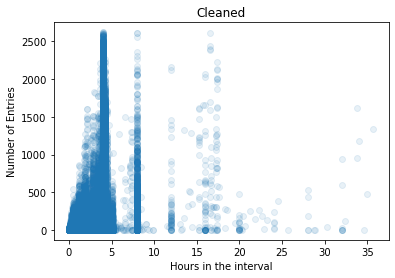

In [313]:
interval_in_hours = cleaned.time_interval.dt.total_seconds() / 3600

plt.scatter(interval_in_hours, cleaned.corrected_entries_since_last_record, alpha=0.1)
plt.xlabel('Hours in the interval')
plt.ylabel('Number of Entries')
plt.title('Cleaned')

## 2.13 Select Relevant Columns

In [315]:
relevant = cleaned[['C/A', 'UNIT', 'SCP', 'STATION', 'DATE', 'TIME', 'datetime', 'corrected_entries_since_last_record', 'time_interval']]
                   

In [317]:
relevant = relevant.rename(columns={'corrected_entries_since_last_record': 'entries'})

In [319]:
relevant.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1009870 entries, 1 to 204594
Data columns (total 9 columns):
C/A              1009870 non-null object
UNIT             1009870 non-null object
SCP              1009870 non-null object
STATION          1009870 non-null object
DATE             1009870 non-null datetime64[ns]
TIME             1009870 non-null object
datetime         1009870 non-null datetime64[ns]
entries          1009870 non-null float64
time_interval    1009870 non-null timedelta64[ns]
dtypes: datetime64[ns](2), float64(1), object(5), timedelta64[ns](1)
memory usage: 77.0+ MB


In [457]:
relevant.head()

,C/A,UNIT,SCP,STATION,DATE,TIME,datetime,entries,time_interval
1,A002,R051,02-00-00,59 ST,2019-02-23,07:00:00,2019-02-23 07:00:00,11.000,04:00:00
2,A002,R051,02-00-00,59 ST,2019-02-23,11:00:00,2019-02-23 11:00:00,60.000,04:00:00
3,A002,R051,02-00-00,59 ST,2019-02-23,15:00:00,2019-02-23 15:00:00,160.000,04:00:00
4,A002,R051,02-00-00,59 ST,2019-02-23,19:00:00,2019-02-23 19:00:00,290.000,04:00:00
5,A002,R051,02-00-00,59 ST,2019-02-23,23:00:00,2019-02-23 23:00:00,143.000,04:00:00


# 3. Store Data

In [321]:
with open('cleaned_mta_data_march.pickle', 'wb') as write_file:
    pickle.dump(relevant, write_file)

# 4. Adjust Intervals That Cross Days

## 4.1 Explore Intervals 

In [340]:
counts = relevant.TIME.value_counts()
counts.head(20)

04:00:00    76541
08:00:00    76492
20:00:00    76428
16:00:00    76403
12:00:00    76385
00:00:00    73916
11:00:00    37790
07:00:00    37784
23:00:00    37764
15:00:00    37737
19:00:00    37703
05:00:00    37650
09:00:00    37650
21:00:00    37610
17:00:00    37605
13:00:00    37573
01:00:00    35824
03:00:00    35308
14:00:00     2820
22:00:00     2817
Name: TIME, dtype: int64

In [343]:
relevant.iloc[0].TIME

datetime.time(7, 0)

In [345]:
relevant[relevant.TIME == datetime.time(0, 0)]

,C/A,UNIT,SCP,STATION,DATE,TIME,datetime,entries,time_interval
11,A002,R051,02-00-00,59 ST,2019-03-11,00:00:00,2019-03-11,80.000,04:00:00
17,A002,R051,02-00-00,59 ST,2019-03-12,00:00:00,2019-03-12,175.000,04:00:00
23,A002,R051,02-00-00,59 ST,2019-03-13,00:00:00,2019-03-13,229.000,04:00:00
32,A002,R051,02-00-00,59 ST,2019-03-14,00:00:00,2019-03-14,217.000,04:00:00
39,A002,R051,02-00-00,59 ST,2019-03-15,00:00:00,2019-03-15,249.000,04:00:00
...,...,...,...,...,...,...,...,...,...
203968,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2019-03-06,00:00:00,2019-03-06,0.000,04:00:00
203974,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2019-03-07,00:00:00,2019-03-07,0.000,04:00:00
203981,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2019-03-08,00:00:00,2019-03-08,0.000,04:00:00
201750,TRAM2,R469,00-05-01,RIT-ROOSEVELT,2019-03-09,00:00:00,2019-03-09,0.000,04:00:00


In [332]:
import datetime

d1 = pd.to_datetime('1/2/2019 03:00')
d2 = d1 - pd.Timedelta('4 hours')

In [330]:
d1.day

2

In [333]:
d2.day

1

In [346]:
td = pd.Timedelta('4 hours')
td.total_seconds() / 3600

4.0

In [348]:
pd.to_datetime('1/2/2019 03:00').hour

3

In [365]:
more_than_one_day = relevant[relevant.datetime.dt.hour < (relevant.time_interval.dt.total_seconds() / 3600)]

more_than_one_day.shape[0] / relevant.shape[0]

0.16440333904363927

16% of the records are overlapping a day

In [367]:
and_at_midnight = more_than_one_day[more_than_one_day.TIME == datetime.time(0, 0)]
and_at_midnight.shape[0] / more_than_one_day.shape[0]

0.44520737715779457

Of that 16%, almost half of them are at midnight

In [364]:
(relevant[relevant.time_interval.dt.total_seconds() >= (24 * 3600)].shape[0] / relevant.shape[0]) * 100

0.0028716567478982444

Less than 0.001% of the records are larger than 1 day. Perhaps remove

Plan Below:

In [368]:
# remove records with intervals >= 24 hours
# add a starting datetime field
    # start_datetime = datetime - time_interval
    # rename datetime -> 'end_datetime'
# drop DATE, TIME
# replace all datetime values of 00:00 with 23:59 of the prev day
 
# if starting_datetime and end_datetime are on different days
    # insert tomorrow's record:
        # station values: same
        # start_datetime: 00:00
        # end_datetime: end_datetime from record
        # entries: proportional
        # time_interval: end_datetime - start_datetime
    # ajust values:
        # entries: proportion of interval on the starting day
        # end_datetime: 23:59
        # time_interval: end_datetime - start_datetime
        

## 4.2 Clean Datetime Fields

In [369]:
less_than_24 = relevant[relevant.time_interval < pd.Timedelta('24 hours')].copy()

In [372]:
less_than_24['start_datetime'] = less_than_24.datetime - less_than_24.time_interval

In [373]:
less_than_24 = less_than_24.rename(columns={ 'datetime': 'end_datetime'})

In [375]:
less_than_24 = less_than_24.drop(columns=['DATE', 'TIME'])

In [383]:
less_than_24['end_datetime'] = np.where(
    less_than_24.end_datetime.dt.hour == 0,
    less_than_24.end_datetime - pd.Timedelta('1 second'),
    less_than_24.end_datetime
)

## 4.3 Split Entries That Overlap Days

### 4.3.1 Append Records for Next Day's Entries

In [416]:
less_than_24.head()

,C/A,UNIT,SCP,STATION,end_datetime,entries,time_interval,start_datetime
1,A002,R051,02-00-00,59 ST,2019-02-23 07:00:00,11.000,04:00:00,2019-02-23 03:00:00
2,A002,R051,02-00-00,59 ST,2019-02-23 11:00:00,60.000,04:00:00,2019-02-23 07:00:00
3,A002,R051,02-00-00,59 ST,2019-02-23 15:00:00,160.000,04:00:00,2019-02-23 11:00:00
4,A002,R051,02-00-00,59 ST,2019-02-23 19:00:00,290.000,04:00:00,2019-02-23 15:00:00
5,A002,R051,02-00-00,59 ST,2019-02-23 23:00:00,143.000,04:00:00,2019-02-23 19:00:00


In [403]:
def set_datetime_to_midnight(date):
    return date.replace(hour=0, minute=0, second=0)

In [412]:
new_records = less_than_24[less_than_24.start_datetime.dt.day != less_than_24.end_datetime.dt.day].copy()
new_records['new_start_datetime'] = new_records.end_datetime.map(set_datetime_to_midnight)
new_records['interval_on_that_day'] = new_records.end_datetime - new_records.new_start_datetime

In [414]:
new_records['proportional_entries'] = new_records.entries * (new_records.interval_on_that_day / new_records.time_interval)

In [418]:
new_records['entries'] = new_records['proportional_entries']
new_records['time_interval'] = new_records['interval_on_that_day']
new_records['start_datetime'] = new_records['new_start_datetime']
records_to_add = new_records[['C/A','UNIT','SCP','STATION','end_datetime','entries','time_interval','start_datetime']]

In [434]:
with_split = less_than_24.append(records_to_add)

### 4.3.2 Reset Records With Only Today's Value

In [436]:
with_split['new_end_datetime'] = np.where(
    with_split.start_datetime.dt.day != with_split.end_datetime.dt.day,
    with_split.end_datetime.map(lambda date: (date - pd.Timedelta('1 day')).replace(hour=23, minute=59, second=59)),
    with_split.end_datetime
)

In [437]:
with_split[with_split.end_datetime != with_split.new_end_datetime].new_end_datetime.unique()

array(['2019-02-23T23:59:59.000000000', '2019-02-24T23:59:59.000000000',
       '2019-02-25T23:59:59.000000000', '2019-02-26T23:59:59.000000000',
       '2019-02-27T23:59:59.000000000', '2019-02-28T23:59:59.000000000',
       '2019-03-01T23:59:59.000000000', '2019-03-02T23:59:59.000000000',
       '2019-03-03T23:59:59.000000000', '2019-03-04T23:59:59.000000000',
       '2019-03-05T23:59:59.000000000', '2019-03-06T23:59:59.000000000',
       '2019-03-07T23:59:59.000000000', '2019-03-08T23:59:59.000000000',
       '2019-03-09T23:59:59.000000000', '2019-03-10T23:59:59.000000000',
       '2019-03-11T23:59:59.000000000', '2019-03-12T23:59:59.000000000',
       '2019-03-13T23:59:59.000000000', '2019-03-14T23:59:59.000000000',
       '2019-03-15T23:59:59.000000000', '2019-03-16T23:59:59.000000000',
       '2019-03-17T23:59:59.000000000', '2019-03-18T23:59:59.000000000',
       '2019-03-19T23:59:59.000000000', '2019-03-20T23:59:59.000000000',
       '2019-03-21T23:59:59.000000000', '2019-03-22

In [438]:
with_split['interval_on_that_day'] = with_split.new_end_datetime - with_split.start_datetime

In [439]:
with_split['adjusted_entries'] = np.where(
    with_split.start_datetime.dt.day != with_split.end_datetime.dt.day,
    with_split.entries * (with_split.interval_on_that_day / with_split.time_interval),
    with_split.entries
)

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/arrays/timedeltas.py:597: RuntimeWarning: invalid value encountered in true_divide
  return other / self._data


In [443]:
with_split[with_split.entries != with_split.adjusted_entries].sample(10)

,C/A,UNIT,SCP,STATION,end_datetime,entries,time_interval,start_datetime,new_end_datetime,interval_on_that_day,adjusted_entries
55123,N073,R013,02-00-04,34 ST-PENN STA,2019-03-03 03:00:00,43.000,04:00:00,2019-03-02 23:00:00,2019-03-02 23:59:59,00:59:59,10.747
89356,N340A,R115,01-03-00,169 ST,2019-03-04 03:00:00,14.000,04:00:00,2019-03-03 23:00:00,2019-03-03 23:59:59,00:59:59,3.499
149897,R203,R043,00-03-00,WALL ST,2019-03-23 02:00:00,43.000,04:00:00,2019-03-22 22:00:00,2019-03-22 23:59:59,01:59:59,21.497
102343,N529,R257,00-00-02,EAST BROADWAY,2019-03-03 03:00:00,18.000,04:00:00,2019-03-02 23:00:00,2019-03-02 23:59:59,00:59:59,4.499
38986,J023,R436,00-00-00,NORWOOD AV,2019-03-16 01:00:00,57.000,04:00:00,2019-03-15 21:00:00,2019-03-15 23:59:59,02:59:59,42.746
588,A006,R079,00-00-01,5 AV/59 ST,2019-03-10 01:00:00,109.000,04:00:00,2019-03-09 21:00:00,2019-03-09 23:59:59,02:59:59,81.742
103263,N533,R129,02-06-02,BERGEN ST,2019-03-26 01:00:00,60.000,04:00:00,2019-03-25 21:00:00,2019-03-25 23:59:59,02:59:59,44.996
14178,B014,R148,00-00-01,PARKSIDE AV,2019-03-19 01:00:00,86.000,04:00:00,2019-03-18 21:00:00,2019-03-18 23:59:59,02:59:59,64.494
13716,B004,R171,00-00-00,7 AV,2019-03-25 01:00:00,89.000,04:00:00,2019-03-24 21:00:00,2019-03-24 23:59:59,02:59:59,66.744
109251,N603,R303,00-00-00,21 ST-QNSBRIDGE,2019-02-27 03:00:00,14.000,04:00:00,2019-02-26 23:00:00,2019-02-26 23:59:59,00:59:59,3.499


In [442]:
with_split[with_split.start_datetime.dt.day != with_split.new_end_datetime.dt.day]

,C/A,UNIT,SCP,STATION,end_datetime,entries,time_interval,start_datetime,new_end_datetime,interval_on_that_day,adjusted_entries


In [444]:
clean_columns = with_split[['C/A', 'UNIT', 'SCP', 'STATION', 'start_datetime', 'new_end_datetime', 'interval_on_that_day', 'adjusted_entries']]

In [446]:
clean_columns = clean_columns.rename(columns={ 'new_end_datetime': 'end_datetime', 'adjusted_entries': 'entries' })


In [448]:
clean_columns.sample(10)

,C/A,UNIT,SCP,STATION,start_datetime,end_datetime,interval_on_that_day,entries
191048,R551,R072,01-03-03,34 ST-HUDSON YD,2019-03-01 07:00:00,2019-03-01 11:00:00,04:00:00,79.000
55974,N077,R111,02-06-02,23 ST,2019-03-05 23:00:00,2019-03-05 23:59:59,00:59:59,3.749
167920,R291,R183,00-00-02,BEDFORD PK BLVD,2019-03-07 15:00:00,2019-03-07 19:00:00,04:00:00,601.000
162152,R250,R179,00-00-02,86 ST,2019-03-17 04:00:00,2019-03-17 08:00:00,04:00:00,33.000
35494,H038,R350,00-00-02,LIVONIA AV,2019-03-24 17:00:00,2019-03-24 21:00:00,04:00:00,109.000
79403,N316A,R267,01-03-01,46 ST,2019-03-11 01:00:00,2019-03-11 05:00:00,04:00:00,4.000
189334,R550,R072,00-03-09,34 ST-HUDSON YD,2019-03-14 08:00:00,2019-03-14 12:00:00,04:00:00,50.000
22655,C016,R278,00-00-01,25 ST,2019-03-29 08:00:00,2019-03-29 12:00:00,04:00:00,282.000
59045,N092,R029,03-03-00,CHAMBERS ST,2019-03-27 12:00:00,2019-03-27 16:00:00,04:00:00,466.000
19734,B032,R264,00-00-02,OCEAN PKWY,2019-03-28 08:00:00,2019-03-28 12:00:00,04:00:00,229.000


### 4.3.3 Validation

In [450]:
num_in_less_than_24 = less_than_24.shape[0]
num_across_days = less_than_24[less_than_24.start_datetime.dt.day != less_than_24.end_datetime.dt.day].shape[0]
num_in_clean_cols = clean_columns.shape[0]

num_in_clean_cols == (num_in_less_than_24 + num_across_days)

True

In [451]:
clean_columns[clean_columns.start_datetime.dt.day != clean_columns.end_datetime.dt.day].shape[0]

0

In [453]:
clean_columns.shape[0] / mta_data.shape[0]

1.0821472323216421

## 4.4 Store Data

In [452]:
with open('super_cleaned_mta_data_march.pickle', 'wb') as write_file:
    pickle.dump(clean_columns, write_file)

In [459]:
clean_columns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1099770 entries, 1 to 204589
Data columns (total 8 columns):
C/A                     1099770 non-null object
UNIT                    1099770 non-null object
SCP                     1099770 non-null object
STATION                 1099770 non-null object
start_datetime          1099770 non-null datetime64[ns]
end_datetime            1099770 non-null datetime64[ns]
interval_on_that_day    1099770 non-null timedelta64[ns]
entries                 1099770 non-null float64
dtypes: datetime64[ns](2), float64(1), object(4), timedelta64[ns](1)
memory usage: 75.5+ MB


# Explore

In [466]:
res = clean_columns.groupby(['C/A', 'UNIT', 'SCP', 'STATION', clean_columns.start_datetime.dt.strftime('%m/%d/%y')]).agg({ 'entries': 'sum'})

In [463]:
pd.to_datetime('1/1/2019').strftime('%m/%d/%y')

'01/01/19'

In [467]:
res.describe()

,entries
count,168953.000
mean,1033.929
std,995.819
min,0.000
25%,243.000
50%,784.000
75%,1556.490
max,8188.000
